In [544]:
#py download-kline.py -t spot -s BTCUSDT -i 30m -y 2023 -m 07 -skip-daily 1 

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import backtrader as bt
from zipfile import ZipFile
import json
import datetime

In [545]:
poc_list = []
with open('..\scripts\poclist.json') as f:
    poc_list = json.load(f)
df_poc = pd.DataFrame(poc_list)
df_poc['date'] = pd.to_datetime(df_poc['date'])
df_poc = df_poc.set_index('date')
df_poc = df_poc.tz_localize(None)
df_poc['valid'] = 1
print(df_poc)

                 poc  valid
date                       
2023-07-01  30572.57      1
2023-07-02  30515.00      1
2023-07-03  30640.27      1
2023-07-04  30998.00      1
2023-07-05  30424.00      1
2023-07-06  30242.45      1
2023-07-07  30093.02      1
2023-07-08  30248.47      1
2023-07-09  30277.12      1
2023-07-10  30188.00      1
2023-07-11  30396.00      1
2023-07-12  30728.00      1
2023-07-13  30923.00      1
2023-07-14  30222.00      1
2023-07-15  30300.00      1
2023-07-16  30292.29      1
2023-07-17  30261.20      1
2023-07-18  29792.00      1
2023-07-19  29989.96      1
2023-07-20  29794.96      1
2023-07-21  29882.34      1
2023-07-22  29877.10      1
2023-07-23  29898.00      1
2023-07-24  29099.90      1
2023-07-25  29131.65      1
2023-07-26  29288.94      1
2023-07-27  29467.85      1
2023-07-28  29219.12      1
2023-07-29  29286.18      1
2023-07-30  29309.24      1
2023-07-31  29389.80      1


In [546]:
df = pd.read_csv(ZipFile("../data/spot/monthly/klines/BTCUSDT/15m/BTCUSDT-15m-2023-07.zip").open("BTCUSDT-15m-2023-07.csv"),parse_dates=True, names=["datetime","open","high","low","close","volume","close_time","quote_asset_volume","nr_of_trades","taker_buy_base_asset_volume","taker_buy_quote_asset_volume","ignore"])
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
df = df.set_index("datetime")
df = df[df.index <= datetime.datetime(2023, 7, 31)]
print(df.head())

                         open      high       low     close     volume  \
datetime                                                                 
2023-07-01 00:00:00  30471.99  30516.70  30420.00  30447.72  376.13160   
2023-07-01 00:15:00  30447.71  30533.56  30447.71  30516.01  263.01725   
2023-07-01 00:30:00  30516.00  30534.74  30491.14  30516.00  371.36861   
2023-07-01 00:45:00  30516.00  30516.00  30462.00  30469.83  234.44647   
2023-07-01 01:00:00  30469.82  30484.31  30410.25  30476.84  305.21027   

                        close_time  quote_asset_volume  nr_of_trades  \
datetime                                                               
2023-07-01 00:00:00  1688170499999        1.146407e+07         10413   
2023-07-01 00:15:00  1688171399999        8.017958e+06          8568   
2023-07-01 00:30:00  1688172299999        1.133412e+07          8100   
2023-07-01 00:45:00  1688173199999        7.145073e+06          7350   
2023-07-01 01:00:00  1688174099999        9.29549

In [547]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date()
        #print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.date =  self.datetime
        self.dataopen = self.datas[0].open
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                print('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                print('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        
        df_poc_date = df_poc.loc[(self.date.datetime(ago=0) > (df_poc.index + datetime.timedelta(days=1))) & (df_poc['valid'] == 1)].copy()
        
        if self.order:
            return

       
            
        # Not yet ... we MIGHT BUY if ...
        if len(df_poc_date) > 0:
            
            if self.datalow[-1] <= df_poc_date['poc'].values[0] * 1.002 and self.dataclose[-1] > df_poc_date['poc'].values[0] and self.dataopen[-1] > df_poc_date['poc'].values[0]:
                    # current close less than previous close
                    print('poc date', df_poc_date.index[0], 'poc value', df_poc_date['poc'].values[0],'close candle', self.dataclose[0], 'low candle', self.datalow[0])
                    print('buy date', self.date.datetime(ago=0), 'BUY CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    
                    self.order = self.buy()
                    
                    df_poc.loc[df_poc_date.index[0], 'valid'] = 0
                    

        # Already in the market ... we might sell
        if self.position.size > 0:
            
            if len(self) >= (self.bar_executed + 16):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                print(self.date.datetime(ago=0), 'SELL CREATE, %.2f' % self.dataclose[0])
    
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

Starting Portfolio Value: 100000.00
poc date 2023-07-01 00:00:00 poc value 30572.57 close candle 30575.77 low candle 30568.31
buy date 2023-07-02 00:45:00 BUY CREATE, 30575.77
BUY EXECUTED, 30575.77
2023-07-02 05:00:00 SELL CREATE, 30521.99
SELL EXECUTED, 30521.99
poc date 2023-07-02 00:00:00 poc value 30515.0 close candle 30596.0 low candle 30576.95
buy date 2023-07-03 12:15:00 BUY CREATE, 30596.00
BUY EXECUTED, 30596.01
2023-07-03 16:30:00 SELL CREATE, 30973.70
SELL EXECUTED, 30973.70
poc date 2023-07-03 00:00:00 poc value 30640.27 close candle 30726.42 low candle 30620.0
buy date 2023-07-04 19:30:00 BUY CREATE, 30726.42
BUY EXECUTED, 30726.43
2023-07-04 23:45:00 SELL CREATE, 30766.51
SELL EXECUTED, 30766.52
poc date 2023-07-04 00:00:00 poc value 30998.0 close candle 31130.03 low candle 31064.67
buy date 2023-07-06 10:00:00 BUY CREATE, 31130.03
BUY EXECUTED, 31130.03
poc date 2023-07-05 00:00:00 poc value 30424.0 close candle 30373.47 low candle 30310.0
buy date 2023-07-06 13:45:00 B

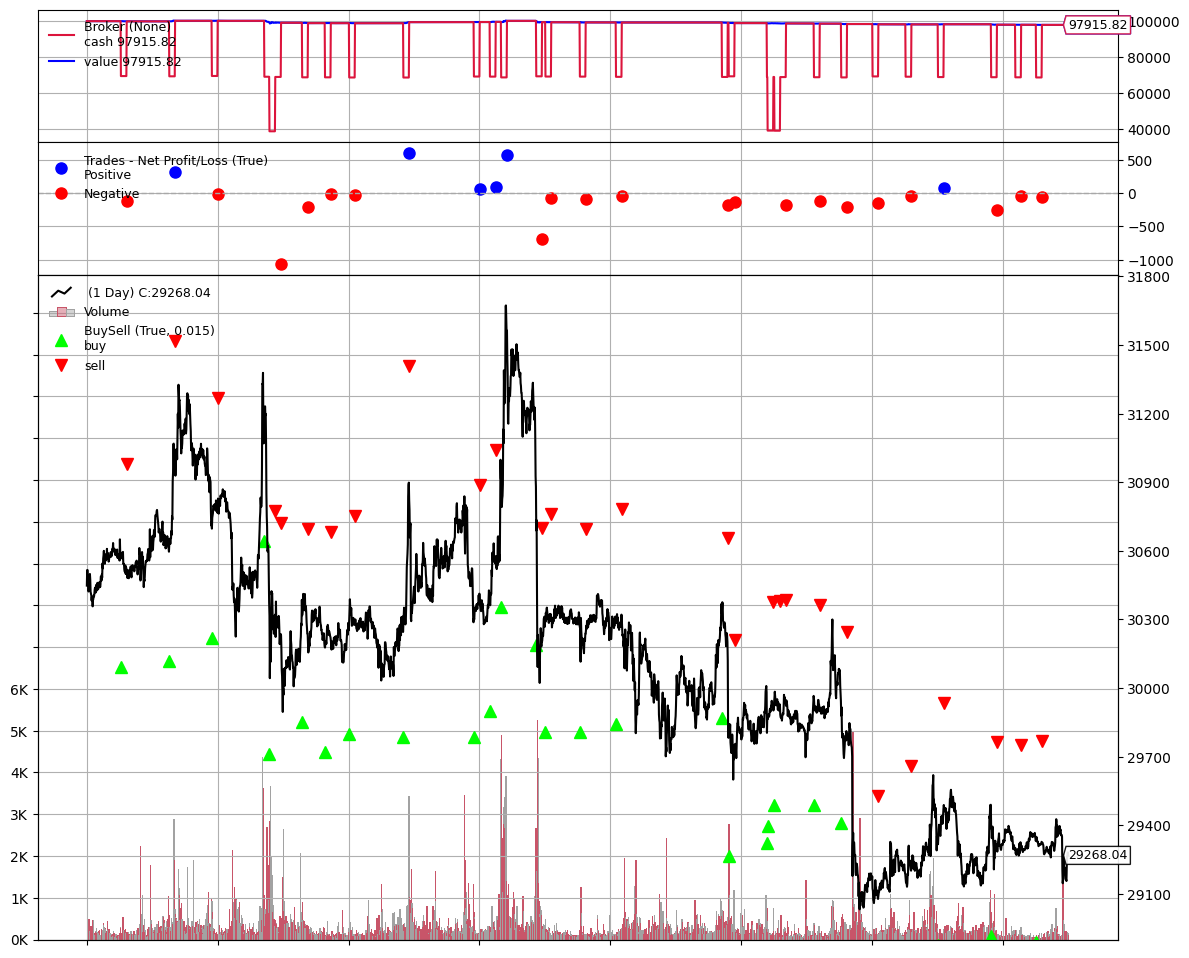

[[<Figure size 1200x1000 with 4 Axes>]]

In [548]:
%matplotlib inline
cerebro = bt.Cerebro()

cerebro.addstrategy(TestStrategy)

data = bt.feeds.PandasData(dataname=df)

cerebro.adddata(data)

cerebro.broker.setcash(100000.0)

cerebro.broker.setcommission(commission=0.001)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


plt.rcParams['figure.figsize']=[12, 10]
cerebro.plot(plotter=None, numfigs=1, iplot=False, ytight= False,yadjust = 0.1)